In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
import shutil
from sklearn.utils import shuffle

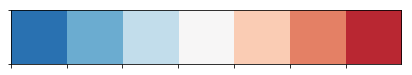

In [4]:
import seaborn as sns
sns.palplot(sns.color_palette("RdBu_r", 7))

sns.set_style("whitegrid")

# Importando base de dados

<p>Base com todos os dados do sudeste</p>

In [5]:
df = pd.read_csv('../data/sudeste.csv',low_memory=False)
print len(df)

9779168


<p>Base com todas chuvas EXTREMAS com inicio e fim de cada chuva extrema (> 50mm em 24 horas)</p>

In [6]:
dfhr = pd.read_csv('../data/extreme_prcp_evolution.csv')
print len(dfhr)

31710


<p>Subconjunto da base principal considerando o inicio e fim das chuvas extremas (> 50mm em 24 horas)</p>

In [7]:
dfext = pd.read_csv('../data/sudeste_extreme_prcp.csv', index_col=0)
print len(dfext)

761040


# Pré-processamento

In [8]:
dfhr['pstr'] = pd.to_datetime(dfhr['pstr'])
dfhr['pend'] = pd.to_datetime(dfhr['pend'])

In [9]:
dfhr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31710 entries, 0 to 31709
Data columns (total 29 columns):
id      31710 non-null int64
wsid    31710 non-null int64
pstr    31710 non-null datetime64[ns]
pend    31710 non-null datetime64[ns]
psum    31710 non-null float64
1       31710 non-null float64
2       31710 non-null float64
3       31710 non-null float64
4       31710 non-null float64
5       31710 non-null float64
6       31710 non-null float64
7       31710 non-null float64
8       31710 non-null float64
9       31710 non-null float64
10      31710 non-null float64
11      31710 non-null float64
12      31710 non-null float64
13      31710 non-null float64
14      31710 non-null float64
15      31710 non-null float64
16      31710 non-null float64
17      31710 non-null float64
18      31710 non-null float64
19      31710 non-null float64
20      31710 non-null float64
21      31710 non-null float64
22      31710 non-null float64
23      31710 non-null float64
24      31710

In [10]:
df['mdct'] = pd.to_datetime(df['mdct'])
df['date'] = pd.to_datetime(df['date'])

strfld = ['wsnm','inme','city','prov']

for f in strfld:
    df[f] = df[f].astype(str)    

In [11]:
# Campos não numericos e campos derivados
DES= ['wsid','wsnm','elvt','lat','lon','inme','city','prov']
INT = ['yr','mo','da','hr']
DAT = ['mdct','date']
DER = ['smax','smin','tmax','tmin','dmax','dmin','hmax','hmin']

In [12]:
# dataframe apenas com os dados continuos
dfcont = df
for f in DES + INT + DAT:    
    dfcont = dfcont.drop(f, 1)

In [13]:
dfcont.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9779168 entries, 0 to 9779167
Data columns (total 17 columns):
prcp    float64
stp     float64
smax    float64
smin    float64
gbrd    float64
temp    float64
tmax    float64
tmin    float64
dewp    float64
dmax    float64
dmin    float64
hmdy    float64
hmax    float64
hmin    float64
wdsp    float64
wdct    float64
gust    float64
dtypes: float64(17)
memory usage: 1.2 GB


In [14]:
# dataframe com dados continuos mas sem dados derivados
dfcsd = dfcont
for f in DER:    
    dfcsd = dfcsd.drop(f, 1)

<p>Separando apenas o conjunto de precipitações extremas. Ou seja, criando um novo dataframe filtrando apenas os dados medidos no início e fim da chuva extrema </p>

In [15]:
dfext.head(5)

,city,da,date,dewp,dmax,dmin,elvt,gbrd,gust,hmax,...,smin,stp,temp,tmax,tmin,wdct,wdsp,wsid,wsnm,yr
2881,São Gonçalo,5,2008-03-05,23.9,23.6,22.2,237.0,NaN,10.5,91.0,...,982.9,985.0,23.6,22.2,27.3,43.0,1.8,178,SÃO GONÇALO,2008
2882,São Gonçalo,5,2008-03-05,22.5,22.7,21.9,237.0,NaN,8.6,95.0,...,984.7,985.1,23.4,22.5,23.6,62.0,1.2,178,SÃO GONÇALO,2008
2883,São Gonçalo,5,2008-03-05,22.5,23.1,21.9,237.0,NaN,4.1,95.0,...,984.3,984.4,23.1,21.9,23.5,54.0,0.6,178,SÃO GONÇALO,2008
2884,São Gonçalo,5,2008-03-05,21.9,19.7,18.4,237.0,NaN,11.5,95.0,...,983.8,985.2,19.7,18.9,23.1,187.0,5.4,178,SÃO GONÇALO,2008
2885,São Gonçalo,5,2008-03-05,20.6,19.6,18.8,237.0,NaN,11.5,98.0,...,983.7,983.8,21.0,20.6,21.0,221.0,1.3,178,SÃO GONÇALO,2008


In [16]:
# dataframe apenas com os dados continuos (APENAS Chuvas extremas)
order_list = ['wsid','wsnm','elvt','lat','lon','inme','city','prov','mdct','date',\
              'yr','mo','da','hr','prcp','stp','smax','smin','gbrd','temp','tmax','tmin',\
              'dewp','dmax','dmin','hmdy','hmax','hmin','wdsp','wdct','gust','peid']
dfext = dfext.reindex(order_list, axis=1)
dfextcont = dfext

In [17]:
for f in DES + INT + DAT:    
    dfextcont = dfextcont.drop(f, 1)

In [18]:
dfextcont.head(5)

,prcp,stp,smax,smin,gbrd,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust,peid
2881,6.4,985.0,985.2,982.9,NaN,23.6,22.2,27.3,23.9,23.6,22.2,91.0,91.0,76.0,1.8,43.0,10.5,1.0
2882,14.0,985.1,985.4,984.7,NaN,23.4,22.5,23.6,22.5,22.7,21.9,95.0,95.0,92.0,1.2,62.0,8.6,1.0
2883,NaN,984.4,985.1,984.3,NaN,23.1,21.9,23.5,22.5,23.1,21.9,93.0,95.0,93.0,0.6,54.0,4.1,1.0
2884,17.2,985.2,985.6,983.8,NaN,19.7,18.9,23.1,21.9,19.7,18.4,95.0,95.0,90.0,5.4,187.0,11.5,1.0
2885,15.4,983.8,985.1,983.7,NaN,21.0,20.6,21.0,20.6,19.6,18.8,97.0,98.0,95.0,1.3,221.0,11.5,1.0


<h3>Limpeza dos dados</h3>

<p>Vamos ver como os dados contínuos estão organizados: MÍNIMOS, MÁXIMOS, MEDIAS</p>

In [19]:
dfextcont.dropna(inplace=False).head(5)

,prcp,stp,smax,smin,gbrd,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust,peid
3153,0.8,986.0,986.0,985.3,5.025,22.8,22.1,22.8,22.1,22.5,21.7,96.0,96.0,95.0,0.2,156.0,1.0,4.0
3154,17.0,987.1,987.1,986.0,57.139,22.6,21.9,23.0,22.2,22.5,21.8,96.0,96.0,94.0,1.6,150.0,3.5,4.0
3155,21.0,987.4,987.5,987.1,516.903,23.1,22.2,23.3,22.7,21.9,21.3,95.0,97.0,95.0,0.3,25.0,4.6,4.0
3153,0.8,986.0,986.0,985.3,5.025,22.8,22.1,22.8,22.1,22.5,21.7,96.0,96.0,95.0,0.2,156.0,1.0,5.0
3154,17.0,987.1,987.1,986.0,57.139,22.6,21.9,23.0,22.2,22.5,21.8,96.0,96.0,94.0,1.6,150.0,3.5,5.0


In [20]:
dfextcont = dfextcont.apply(pd.to_numeric, errors='coerce')  

In [21]:
dfextcont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 761040 entries, 2881 to 9774300
Data columns (total 18 columns):
prcp    498497 non-null float64
stp     761040 non-null float64
smax    761040 non-null float64
smin    761040 non-null float64
gbrd    442663 non-null float64
temp    761040 non-null float64
tmax    761039 non-null float64
tmin    761040 non-null float64
dewp    761031 non-null float64
dmax    761040 non-null float64
dmin    761040 non-null float64
hmdy    761040 non-null float64
hmax    761040 non-null float64
hmin    761040 non-null float64
wdsp    699166 non-null float64
wdct    761040 non-null float64
gust    743830 non-null float64
peid    761040 non-null float64
dtypes: float64(18)
memory usage: 110.3 MB


<p> A variável gbbr(radiação global) apresenta massivamente números nulos e não pode ser recuperada. Vamos retirar esta variável.</p>

In [22]:
dfextcont = dfextcont.drop('gbrd', 1)
dfcont =  dfcont.drop('gbrd',1)
df = df.drop('gbrd',1)
dfext = dfext.drop('gbrd',1)

In [23]:
dfextcont.describe()

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust,peid
count,498497.000000,761040.000000,761040.000000,761040.000000,761040.000000,761039.000000,761040.000000,761031.000000,761040.000000,761040.000000,761040.000000,761040.000000,761040.000000,699166.000000,761040.000000,743830.000000,761040.000000
mean,4.595885,932.860858,932.927508,932.356014,20.628916,18.654730,21.034582,19.009259,20.278253,18.332398,89.203758,90.647873,87.484752,2.098389,157.019025,5.205312,15855.500000
std,6.947355,108.631918,109.503818,109.447430,3.554264,3.726424,3.710206,3.786107,3.402126,3.703478,14.720075,13.998810,15.565180,1.698764,112.041420,3.201183,9153.894528
min,0.000000,0.000000,0.000000,0.000000,0.000000,-9.900000,0.000000,-9.900000,0.000000,-10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.600000,907.800000,908.000000,907.500000,18.700000,17.600000,19.000000,17.900000,18.500000,17.300000,89.000000,91.000000,86.000000,0.900000,61.000000,3.000000,7928.000000
50%,2.200000,939.800000,940.100000,939.500000,20.700000,19.200000,21.100000,19.600000,20.400000,18.900000,94.000000,94.000000,93.000000,1.700000,131.000000,4.600000,15855.500000
75%,5.400000,981.100000,981.300000,980.800000,22.600000,20.800000,23.000000,21.100000,22.200000,20.400000,96.000000,96.000000,96.000000,2.800000,256.000000,6.800000,23783.000000
max,100.000000,1039.000000,1040.000000,1033.600000,37.800000,33.600000,40.900000,37.500000,36.800000,32.800000,100.000000,100.000000,100.000000,16.300000,360.000000,46.000000,31710.000000


<p>Verificando os MINIMOS, MAXIMOS, MEDIAS... A precipitação 0mm indica que não houve chuva, mas pressão 0 e humidade 0 indica que a estação falhou e são dados inválidos. Desta forma estes registro devem ser excluídos.</p>

In [24]:
dfextcont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 761040 entries, 2881 to 9774300
Data columns (total 17 columns):
prcp    498497 non-null float64
stp     761040 non-null float64
smax    761040 non-null float64
smin    761040 non-null float64
temp    761040 non-null float64
tmax    761039 non-null float64
tmin    761040 non-null float64
dewp    761031 non-null float64
dmax    761040 non-null float64
dmin    761040 non-null float64
hmdy    761040 non-null float64
hmax    761040 non-null float64
hmin    761040 non-null float64
wdsp    699166 non-null float64
wdct    761040 non-null float64
gust    743830 non-null float64
peid    761040 non-null float64
dtypes: float64(17)
memory usage: 104.5 MB


<p>Para as precipitações nulas foi inputado 0.0 mm. Também para o vento e rajada de vento.</p>

In [25]:
CAN_BE_NULL = ['wdsp','prcp','gust','dewp']

In [26]:
for v in CAN_BE_NULL:
    dfextcont[v] = dfextcont[v].fillna(0.0)
    df[v] = df[v].fillna(0.0)
    dfext[v] = dfext[v].fillna(0.0)
    dfcont[v] = dfcont[v].fillna(0.0)  

<p>Excluindo o identificador de chuva extrema</p>

In [27]:
#dfext = dfext.drop('peid',1)
#dfextcont = dfextcont.drop('peid',1)

In [28]:
dfextcont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 761040 entries, 2881 to 9774300
Data columns (total 17 columns):
prcp    761040 non-null float64
stp     761040 non-null float64
smax    761040 non-null float64
smin    761040 non-null float64
temp    761040 non-null float64
tmax    761039 non-null float64
tmin    761040 non-null float64
dewp    761040 non-null float64
dmax    761040 non-null float64
dmin    761040 non-null float64
hmdy    761040 non-null float64
hmax    761040 non-null float64
hmin    761040 non-null float64
wdsp    761040 non-null float64
wdct    761040 non-null float64
gust    761040 non-null float64
peid    761040 non-null float64
dtypes: float64(17)
memory usage: 104.5 MB


<p>Para as variáveis ento Vento Velocidade (m/s), Vento, Direção(graus) e Vento, Rajada Maxima (m/s) os valores nulos foram inputados pela média. </p>

In [29]:
MEAN = ['tmax','dmin','temp','tmin','dmax','dmin','hmin','hmax']

In [30]:
for v in MEAN:
    df[v] = df[v].fillna(value=df[v].median())
    dfext[v] = dfext[v].fillna(value=dfext[v].median())
    dfcont[v] = dfcont[v].fillna(value=dfcont[v].median())
    dfextcont[v] =  dfextcont[v].fillna(value=dfextcont[v].median())

<h2>Mineiração dos dados</h2>

<h3>Preparando a base</h3>

In [31]:
dfm = df
dfm.index = pd.to_datetime(dfm.mdct)
CLEAN = ['wsnm','inme','city','prov','mdct','date']
for v in CLEAN:
    dfm = dfm.drop(v,1)
dfm.head(5)        

,wsid,elvt,lat,lon,yr,mo,da,hr,prcp,stp,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
mdct,,,,,,,,,,,,,,,,,,,,,
2007-11-06 00:00:00,178,237.0,-6.835777,-38.311583,2007,11,6,0,0.0,982.5,...,29.7,16.8,25.5,10.8,35.0,58.0,32.0,3.2,101.0,6.5
2007-11-06 01:00:00,178,237.0,-6.835777,-38.311583,2007,11,6,1,0.0,983.2,...,29.9,13.6,29.0,12.2,39.0,39.0,35.0,3.6,94.0,6.4
2007-11-06 02:00:00,178,237.0,-6.835777,-38.311583,2007,11,6,2,0.0,983.5,...,29.0,14.0,27.4,13.6,44.0,44.0,39.0,2.5,93.0,6.9
2007-11-06 03:00:00,178,237.0,-6.835777,-38.311583,2007,11,6,3,0.0,983.7,...,27.4,16.9,25.8,14.1,58.0,58.0,44.0,1.7,96.0,5.8
2007-11-06 04:00:00,178,237.0,-6.835777,-38.311583,2007,11,6,4,0.0,983.7,...,26.3,17.0,25.3,16.4,57.0,58.0,56.0,3.1,110.0,7.5


In [32]:
dfm.describe().T

,count,mean,std,min,25%,50%,75%,max
wsid,9779168.0,359.253059,39.016300,178.000000,328.000000,358.000000,394.000000,423.0
elvt,9779168.0,594.092256,398.037895,0.000000,283.000000,573.000000,875.000000,1758.0
lat,9779168.0,-20.230815,3.172643,-24.962819,-22.395799,-20.750412,-18.917072,0.0
lon,9779168.0,-44.645904,4.882117,-56.677323,-47.434102,-44.453785,-42.435750,0.0
yr,9779168.0,2011.164228,3.207774,2000.000000,2009.000000,2011.000000,2014.000000,2016.0
mo,9779168.0,6.521960,3.425538,1.000000,4.000000,7.000000,9.000000,12.0
da,9779168.0,15.754651,8.802154,1.000000,8.000000,16.000000,23.000000,31.0
hr,9779168.0,11.500002,6.922190,0.000000,5.000000,12.000000,18.000000,23.0
prcp,9779168.0,0.134858,1.156940,0.000000,0.000000,0.000000,0.000000,100.0
stp,9779168.0,880.429177,248.264986,0.000000,911.300000,944.200000,973.100000,1050.0


<h3>Derivando novas variáveis</h3>

<p>O objetivo é derivar cada variável climática contínua em uma nova variável t-1, t-2, t-3... t-n, onde n é o numeros de horas antes do momento t.</p>

In [33]:
def derive_nth_hour_feature(df, feature, N):  
    rows = df.shape[0]
    nth_prior_measurements = [None]*N + [df[feature][i-N] for i in range(N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = np.nan
    df.loc[:][col_name] = nth_prior_measurements

In [ ]:
NON_DER = ['wsid','elvt','lat', 'lon', 'yr', 'mo', 'da', 'hr']

for feature in dfm.columns:
    if feature not in NON_DER:
        for h in range(1,7):
            derive_nth_hour_feature(dfm, feature, h) 

In [ ]:
dfm.to_csv('../data/sudeste_derived.csv', sep=',', encoding='utf-8')